In [143]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=9
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [144]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)


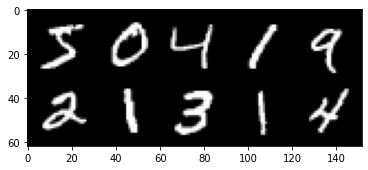

In [145]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [146]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [147]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [148]:
#set up the training routine
mnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)
#print(MNIST_PATH)

In [149]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [150]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [151]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


In [152]:
#predict in distribution
MNIST_PATH = "../trained_weights/MNIST_weights_seed={}.pth".format(s)

mnist_model = NN(num_classes=10)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

#acc = []

#max_len = len(mnist_test_loader)
#for batch_idx, (x, y) in enumerate(mnist_test_loader):
#        output = mnist_model(x)
#        accuracy = get_accuracy(output, y)
#        if batch_idx % 10 == 0:
#            print(
#                "Batch {}/{} \t".format(batch_idx, max_len) + 
#                "Accuracy %.0f" % (accuracy * 100) + "%"
#            )
#        acc.append(accuracy)
#    
#avg_acc = np.mean(acc)
#print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: ../trained_weights/MNIST_weights_seed=9.pth


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [153]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [154]:
#MNIST_NN_Std_prec_1 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=1,verbose=False)
#MNIST_NN_Std_prec_01 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.1,verbose=False)
#MNIST_NN_Std_prec_001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.01,verbose=False)
#MNIST_NN_Std_prec_0001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.001,verbose=False)
#MNIST_NN_Std_prec_00001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.0001,verbose=False)
#MNIST_NN_Std_prec_000001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.00001,verbose=False)
#torch.save(MNIST_NN_Std_prec_1, 'Hessian_prec1_seed1.pth')
#torch.save(MNIST_NN_Std_prec_01, 'Hessian_prec01_seed1.pth')
#torch.save(MNIST_NN_Std_prec_001, 'Hessian_prec001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_0001, 'Hessian_prec0001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_00001, 'Hessian_prec00001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_000001, 'Hessian_prec000001_seed1.pth')

In [155]:
MNIST_NN_Std_prec_1 = torch.load('Hessians/Hessian_prec1_seed{}.pth'.format(s))
MNIST_NN_Std_prec_01 = torch.load('Hessians/Hessian_prec01_seed{}.pth'.format(s))
MNIST_NN_Std_prec_001 = torch.load('Hessians/Hessian_prec001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_0001 = torch.load('Hessians/Hessian_prec0001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_00001 = torch.load('Hessians/Hessian_prec00001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_000001 = torch.load('Hessians/Hessian_prec000001_seed{}.pth'.format(s))

## As you can see, the variance gets smaller, the higher the precision gets

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [156]:
"""
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
"""   

'\nimport seaborn as sns\ndef visualize(tensor):\n    output = tensor[0][0]\n    for i in range(1, len(tensor[0])):\n        output = np.concatenate((output, tensor[0][i]))\n    output = output.transpose(2, 0, 1).reshape(5, -1)\n    heatmap = sns.heatmap(output)\n    plt.xticks = (np.arange(0, step=20))\n    plt.show()\n'

In [157]:
#visualize(MNIST_NN_Hessian_diag_10)

In [158]:
def meancalc(Hessian_diag_x):
    i = 0 
    for name, parameter in mnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean standard deviation of layer {0:s}: {1:.4f}".format(name, mean.item()))
        #print(mean.item(), end =", ")
        i += 1
    


In [159]:
#meancalc(Hessian_diag_x=MNIST_NN_Std_prec_000001)

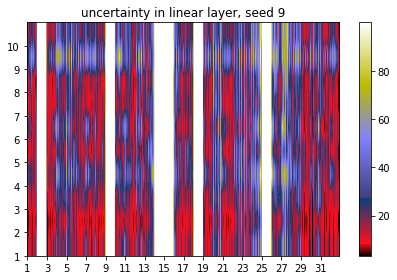

In [160]:
plt.imshow(MNIST_NN_Std_prec_00001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('uncertainty in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

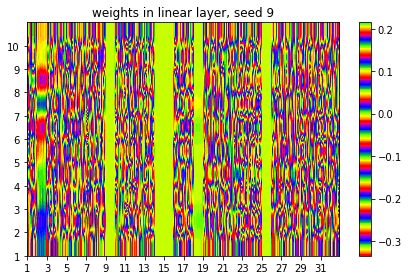

In [161]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        params = parameters

params_arr = params.detach().numpy()

plt.imshow(params_arr, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('weights in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
#plt.hist(params_arr)

In [162]:
def hist_feature(feature):
    to_hist = []
    target_feature = feature
    for i in range(10):
        weight = params[i].detach().numpy()
        weight = np.array_split(np.array(weight), 32)
        to_hist.append(weight[target_feature -1])
    plt.hist(to_hist)
    plt.title('weights in feature {}'.format(target_feature))

In [163]:
#hist_feature(31)

In [164]:
print(MNIST_NN_Std_prec_00001[3][3])
print(MNIST_NN_Std_prec_00001[3][10])


tensor(36.4974)
tensor(15.9159)


In [165]:
#for name, parameters in mnist_model.named_parameters():
 #   if name == '3.weight':
  #      params = parameters

#params_arr = params.detach().numpy()




In [166]:
print(MNIST_NN_Std_prec_00001[2][31][31])
print(MNIST_NN_Std_prec_00001[2].size())

tensor([[74.7965, 69.7088, 67.1596, 67.9394, 71.6451],
        [71.7905, 67.9719, 68.0575, 68.9847, 69.5583],
        [68.3001, 63.8105, 64.1312, 65.7024, 67.0503],
        [77.8454, 74.9587, 73.5877, 72.9962, 76.5994],
        [88.8728, 90.1085, 86.8349, 81.6921, 85.6865]])
torch.Size([32, 32, 5, 5])


# visualize the second conv layer kernels


### first visualize the uncertaintys of the kernels

In [167]:
#fig, axs = plt.subplots(4,8, figsize=(20, 15))
#fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()

#for i in range(32):
    #for j in range(32):
 #   axs[i].imshow(MNIST_NN_Std_prec_0001[2][i][3])

6


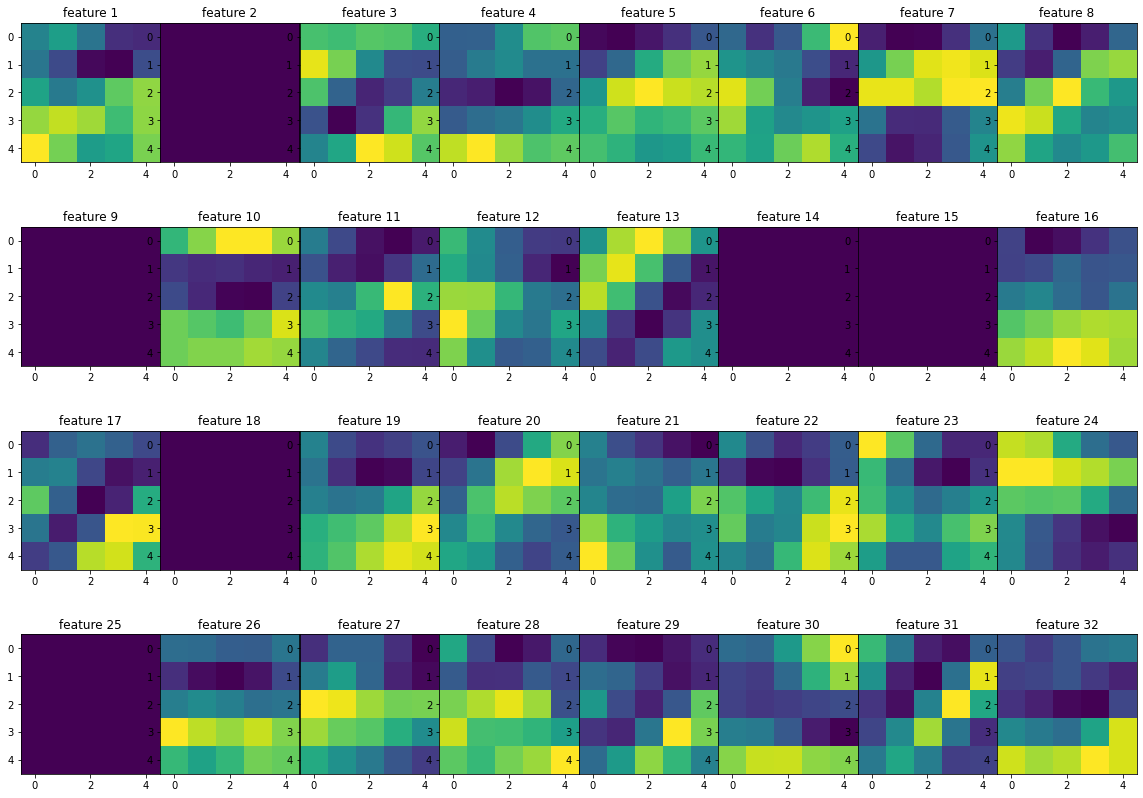

In [168]:
from random import randint

#choose a random between 0 and 31 for 2nd dimension
j = randint(0, 31)

fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
print(j)
for i in range(32):
    #for j in range(32):
    axs[i].imshow(MNIST_NN_Std_prec_00001[2][i][j])
    axs[i].set_title('feature '+str(i+1))
    
#interesting: s2 j24 j7

### in kernels with high uncertainty the biases are maximal (100 for precision 0.0001)

In [169]:
print(MNIST_NN_Std_prec_00001[3])

tensor([ 30.5419, 100.0000,  35.5282,  36.4974,  39.7004,  34.4528,  30.4845,
         28.2082, 100.0000,  36.2399,  15.9159,  32.3580,  29.3855, 100.0000,
        100.0000,  30.6802,  38.1588, 100.0000,  50.8823,  44.2766,  24.4929,
         31.5655,  30.5198,  23.2216, 100.0000,  51.5022,  32.8222,  42.4073,
         30.2059,  36.4454,  23.8882,  45.9029])


## Now viualize the weights of the kernels in the second conv layer (3.weight)

30


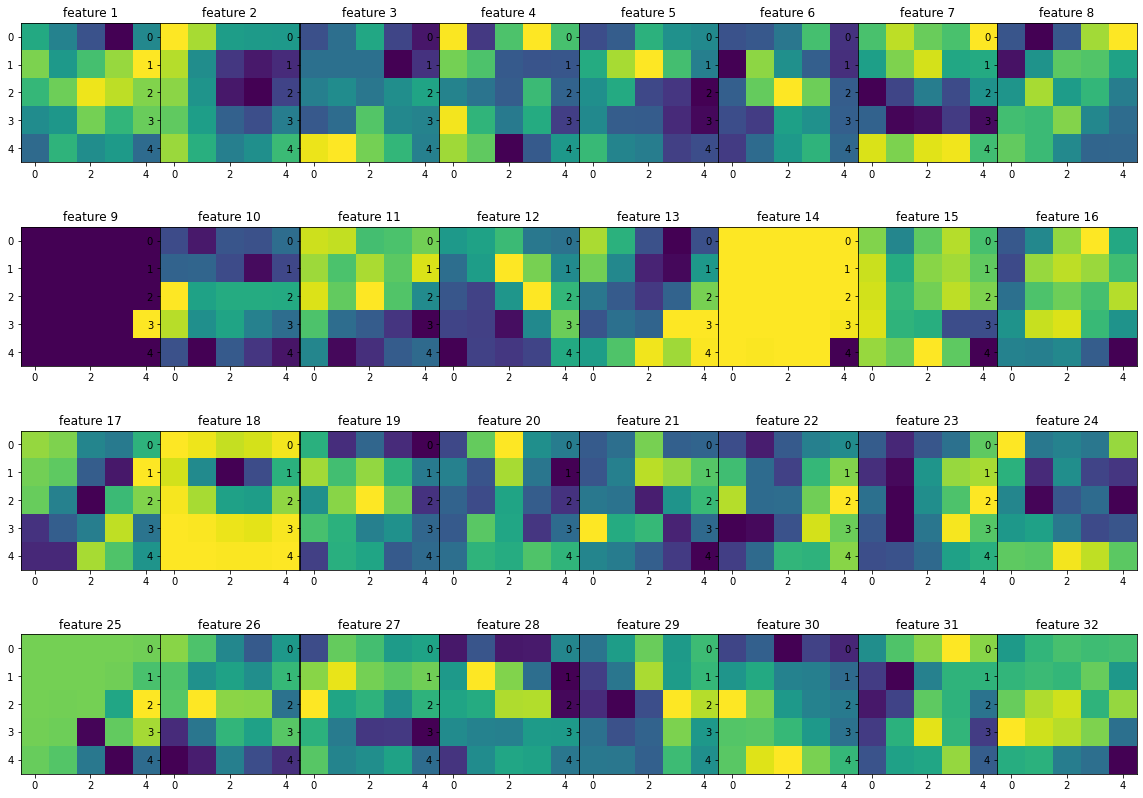

In [170]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#choose random number between 0 and 31 for 2nd dimension
j = randint(0, 31)
print(j)
for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][j])
    axs[i].set_title('feature '+str(i+1))

### look at the biases of the 3rd layer (3.bias)

In [171]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)
#plt.hist(params_arr)

[-2.6357012e-02 -5.5874488e-03 -2.0559035e-02 -3.1781003e-02
 -4.3290742e-02  1.4693246e-02  3.7719052e-02 -1.8076362e-02
 -2.5302437e-04 -1.4612562e-02  8.3642267e-02 -8.5476488e-03
 -1.1243608e-02 -2.2558184e-07  2.5601761e-04  4.9794526e-03
 -2.0842228e-02 -4.0667794e-05  5.9056893e-04 -1.0281459e-02
  2.2838661e-03 -4.1081017e-04  1.5543231e-03  3.0743005e-02
 -4.6044294e-04 -1.8536890e-02  3.1861518e-02 -3.4967244e-02
 -1.7652647e-03 -5.0347587e-03  2.3458317e-02  1.5807007e-02]


## visualize the first conv layers kernels

### first visualize the uncertaintys of the kernels

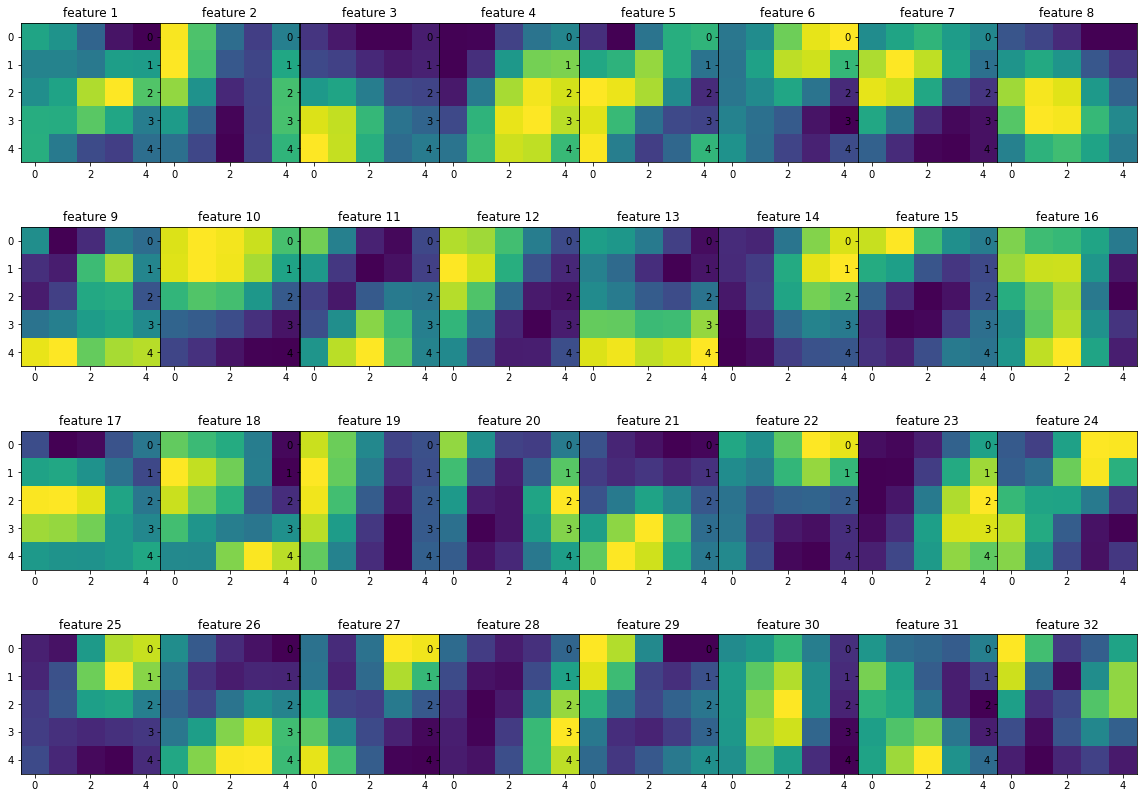

In [172]:
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(MNIST_NN_Std_prec_0001[0][i][0])
    axs[i].set_title('feature '+str(i+1))

In [173]:
print(MNIST_NN_Std_prec_00001[1])

tensor([12.5908, 20.5514, 15.2493,  7.6014, 18.3842, 12.8982, 10.2735,  8.4196,
        15.3689,  6.1795, 22.0961, 13.3420, 19.2707, 12.0114,  6.6529, 29.9990,
        35.4672, 30.2800, 16.1815, 13.6986,  6.7987,  6.8741,  5.4730,  6.3181,
        18.0088, 11.3008, 19.0516,  7.0024, 32.0736,  5.5558, 10.6225, 40.3790])


## now visualize the weights of kernels in first conv layer

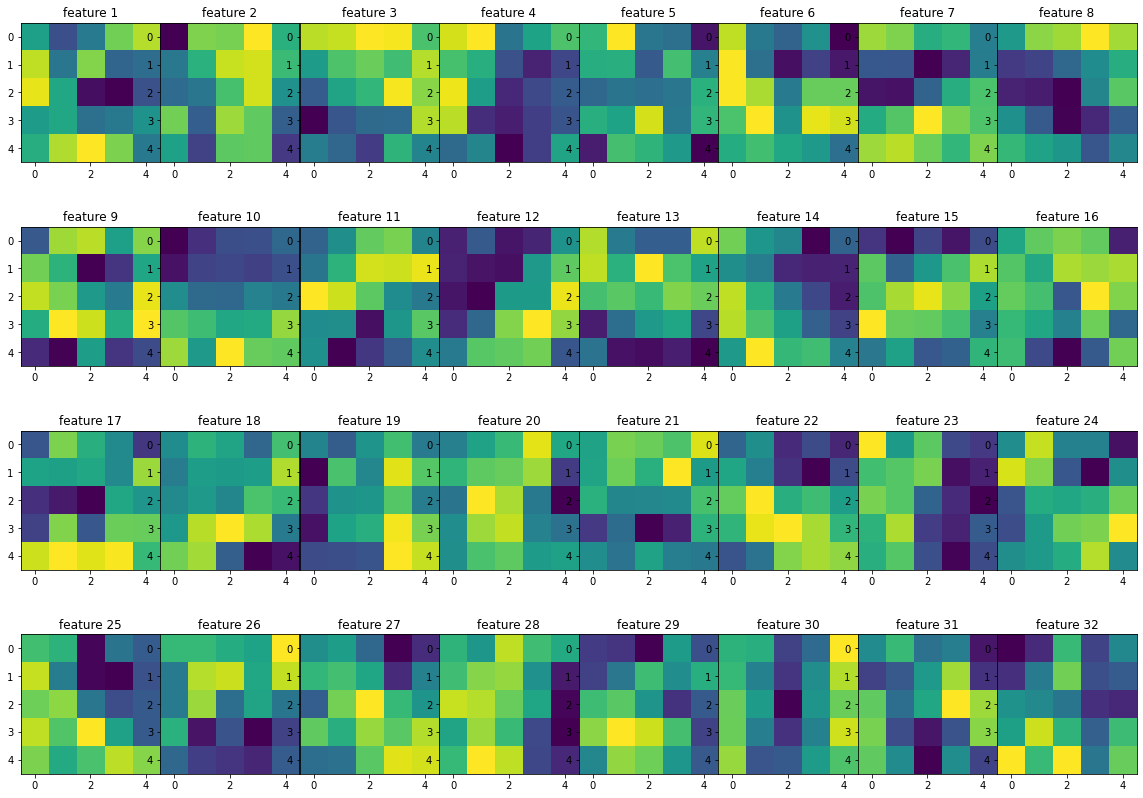

In [174]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][0])
    axs[i].set_title('feature '+str(i+1))

In [175]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)

[-0.01943346 -0.03842145 -0.03115637  0.22877668 -0.00425594 -0.0081576
  0.08273347  0.13361283 -0.05727804  0.15811197 -0.00073035 -0.0019225
  0.01347198 -0.02883488  0.04430558 -0.08479719 -0.0168865  -0.02546574
 -0.03697158 -0.153416    0.03348954  0.12456494  0.195171    0.00222167
 -0.04047667  0.01006282 -0.00460388 -0.1375756   0.00039928 -0.02646381
 -0.00517493  0.00111849]
